In [33]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
path = r'/Users/spencersu/Desktop/Efficacy Studies/Kirtland'
df = pd.read_csv(os.path.join(path, 'Kirtland 19-22.csv'))


## clean the columns

df = df.iloc[:,1:]
df = df.rename(columns = {'Student Id [Sensitive]':'student_id', 'Full Name [Sensitive]':'student_name',
                         'School Year':'school_year','School Name':'school_name','Class Grade Level':'grade',
                         'Teacher Name [Sensitive]':'teacher_name','Lesson Type':'lesson_type',
                         'Multiple Choice Score':'reading_score','Word Count In Final Writing':'word_count',
                         'Number of Graded Writing Lessons':'num_graded_writing','Number of Lessons':'num_lesson'})
df['word_count'] = pd.to_numeric(df['word_count'],errors='coerce')
#df #527 rows × 11 columns

In [16]:
df_kirtland = pd.read_csv(os.path.join(path, 'Last Benchmarker test score.csv'))

## clean the rows and columns
df_kirtland = df_kirtland.iloc[7:,:].reset_index()
df_kirtland.columns = df_kirtland.iloc[0]

df_kirtland = df_kirtland.iloc[1:,:]
df_kirtland[['Last Name','First Name']] = df_kirtland['Student'].str.split(',',expand=True)

df_kirtland['First Name'] = df_kirtland['First Name'].str.strip() # remove the first empty space
df_kirtland['student_name'] = df_kirtland['First Name'] + ' ' + df_kirtland['Last Name']

df_kirtland = df_kirtland.iloc[:,1:]

df_kirtland = df_kirtland.rename(columns = {'Score':'assessment_score','Teacher':'teacher_name',
                                            'Test Grade Level':'grade'})
df_kirtland = df_kirtland.iloc[:,[7,3,2,4]]
#df_kirtland ## 220 rows × 4 columns

In [18]:
merge = pd.merge(df, df_kirtland, on = 'student_name', how='right')
#merge #519 rows × 14 columns

In [19]:
merge

,student_id,student_name,school_year,school_name,grade_x,teacher_name_x,lesson_type,reading_score,word_count,num_graded_writing,num_lesson,grade_y,teacher_name_y,assessment_score
0,1278439.0,Liam Hubbard,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,NaN,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",9%
1,1278439.0,Liam Hubbard,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Writing Lesson,NaN,NaN,0.0,2.0,3,"WATLAND-WRIGHT, MARILYN",9%
2,1278447.0,Sagen Hatathle,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,NaN,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",13%
3,1278447.0,Sagen Hatathle,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Writing Lesson,NaN,NaN,0.0,2.0,3,"WATLAND-WRIGHT, MARILYN",13%
4,1278433.0,Jeremiah Maize,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,40.0,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",11%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,1271223.0,Elizabeth Yazzie,2021-2022,Kirtland Elementary School,6.0,Paula Thompson,Benchmark - Leveling,12.5,NaN,0.0,1.0,-,"GEORGINA, NORMAN",-
515,1271223.0,Elizabeth Yazzie,2021-2022,Kirtland Elementary School,6.0,Paula Thompson,Benchmark - Leveling,100.0,NaN,0.0,2.0,-,"GEORGINA, NORMAN",-
516,NaN,Isiah Collin Cooley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,"MCCALL, JUNE",-
517,NaN,Katelyn Clitso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,"THOMPSON, POLLEY",-


## Data Overview

### 1. School Level Usage
p.s. Num of students participating (start a lesson), num of lessons, num of graded writing lessons
1. (a) the number of students start a lesson for each lesson type (student:benchmark=1:1)

In [5]:
print(df.groupby(['lesson_type'])['student_id'].nunique())

lesson_type
Benchmark - Baseline Writing     39
Benchmark - Leveling             58
Reading Practice                 97
Writing Lesson                  162
Name: student_id, dtype: int64


In [6]:
df[df['lesson_type'] == 'Writing Lesson'].groupby(['student_id'])['num_lesson'].sum().sort_values(ascending=False)

student_id
1278730    3
1279660    3
1279658    3
1279657    3
1278737    3
          ..
1271182    1
1271183    1
1271184    1
1271185    1
1285436    1
Name: num_lesson, Length: 162, dtype: int64

## T-test for usage vs. non-usage

In [79]:
usage = merge[~merge['num_lesson'].isna()]
usage['assessment_score'] = usage['assessment_score'].replace("-",np.NaN)
usage['assessment_score'] = usage['assessment_score'].apply(lambda x: float(str(x).replace("%", ""))/100)
usage = usage[~usage['assessment_score'].isna()]

nonusage = merge[merge['num_lesson'].isna()]
nonusage['assessment_score'] = nonusage['assessment_score'].replace("-",np.NaN)
nonusage['assessment_score'] = nonusage['assessment_score'].apply(lambda x: float(str(x).replace("%", ""))/100)
nonusage = nonusage[~nonusage['assessment_score'].isna()]

In [31]:
# usage['assessment_score'].isnull().values.any() # test if there is nan in a column

False

In [59]:
stats.ttest_ind(usage['assessment_score'], nonusage['assessment_score'])

Ttest_indResult(statistic=-1.627200903108797, pvalue=0.1056621712703366)

In [69]:
merge[~merge['reading_score'].isna()]['reading_score'] # maybe we can take a look at reading score?

4       40.0
10      20.0
11      20.0
13      20.0
21      80.0
       ...  
508     75.0
510     60.0
511    100.0
514     12.5
515    100.0
Name: reading_score, Length: 206, dtype: float64

In [63]:
usage['student_name'].nunique()

59

In [64]:
nonusage['student_name'].nunique()

63

## boxplot

In [80]:
usage['usage'] = 1
nonusage['usage'] = 0
merge2 = pd.concat([usage,nonusage])

In [82]:
merge2

,student_id,student_name,school_year,school_name,grade_x,teacher_name_x,lesson_type,reading_score,word_count,num_graded_writing,num_lesson,grade_y,teacher_name_y,assessment_score,usage
0,1278439.0,Liam Hubbard,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,NaN,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",0.09,1
1,1278439.0,Liam Hubbard,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Writing Lesson,NaN,NaN,0.0,2.0,3,"WATLAND-WRIGHT, MARILYN",0.09,1
2,1278447.0,Sagen Hatathle,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,NaN,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",0.13,1
3,1278447.0,Sagen Hatathle,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Writing Lesson,NaN,NaN,0.0,2.0,3,"WATLAND-WRIGHT, MARILYN",0.13,1
4,1278433.0,Jeremiah Maize,2021-2022,Kirtland Elementary School,3.0,Marilyn Watland-Wright,Reading Practice,40.0,NaN,0.0,1.0,3,"WATLAND-WRIGHT, MARILYN",0.11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,NaN,Hailey Robinson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"Jacquez, Tyra",0.26,0
227,NaN,Payton Roop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"Jacquez, Tyra",0.36,0
228,NaN,Lesheledra Thompson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"Jacquez, Tyra",0.20,0
229,NaN,Nori Velarde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"Jacquez, Tyra",0.54,0


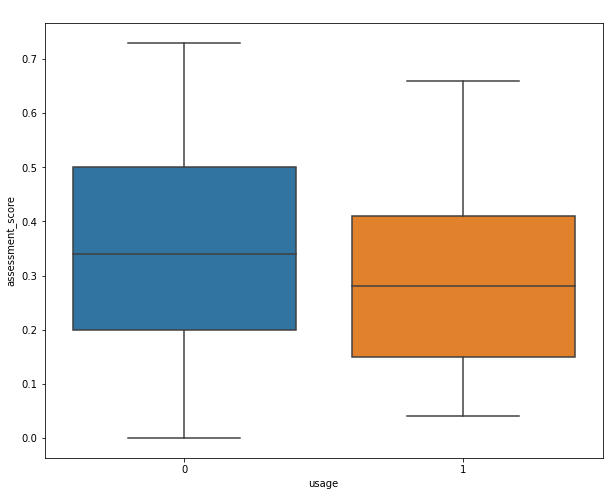

In [85]:
plt.figure(figsize = (10,8))
ax = sns.boxplot(x=merge2['usage'],y=merge2['assessment_score'])
ax.set_title(' ')
#     plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
plt.show()

## Regression

In [99]:
x = merge2.groupby(['student_name','grade_y'])['num_lesson'].sum()

In [100]:
y = merge2.groupby(['student_name','grade_y'])['assessment_score'].mean()

In [101]:
reg = pd.merge(x,y,on=['student_name','grade_y'],how='inner')

In [90]:
merge2.groupby('teacher_name_y')['assessment_score'].mean().sort_values(ascending=False)

teacher_name_y
EMERY, SANDRA              0.393030
Jacquez, Tyra              0.370000
BILLEY, ELSIE              0.355294
BRYANT, LUCINDA            0.346111
Edsitty, Charmayne         0.344118
Goimarac, Greg             0.298235
WATLAND-WRIGHT, MARILYN    0.222619
BILLIE, RASHINDA           0.040000
Name: assessment_score, dtype: float64

In [106]:
reg = reg.reset_index()

In [107]:
results = smf.ols('assessment_score ~ num_lesson + C(grade_y)', data=reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       assessment_score   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.035
Date:                Wed, 17 Aug 2022   Prob (F-statistic):             0.0319
Time:                        11:24:58   Log-Likelihood:                 43.252
No. Observations:                 122   AIC:                            -78.50
Df Residuals:                     118   BIC:                            -67.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4130      0.040     